## The Problem

- Use transfer learning to make a ML model to classify Arabic and English book

## Setup The Notebook

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from pathlib import Path

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get The Data

In [4]:
#Unzip the data file uploaded manually to google colab
!unzip ArabicVsEnglish.zip

Archive:  ArabicVsEnglish.zip
   creating: Arabic Vs English/
   creating: Arabic Vs English/test/
   creating: Arabic Vs English/test/Arabic/
  inflating: Arabic Vs English/test/Arabic/247671.jpg  
  inflating: Arabic Vs English/test/Arabic/312107.jpg  
  inflating: Arabic Vs English/test/Arabic/377305.jpg  
  inflating: Arabic Vs English/test/Arabic/385842.jpg  
  inflating: Arabic Vs English/test/Arabic/390757.jpg  
  inflating: Arabic Vs English/test/Arabic/397040.jpg  
   creating: Arabic Vs English/test/English/
  inflating: Arabic Vs English/test/English/080b72b273c766c88bd8f286aad89495aa0342da_631437.jpg  
  inflating: Arabic Vs English/test/English/2cdd9b0d92ed683909f5277b03366670ea00baa3_618130.jpg  
  inflating: Arabic Vs English/test/English/376058.jpg  
  inflating: Arabic Vs English/test/English/382bd25dfe1eb5c3832ab6c86d7e3cec89fe4921_646353.jpg  
  inflating: Arabic Vs English/test/English/537810.jpg  
  inflating: Arabic Vs English/test/English/8276d44f4ace511ee30a1850

In [6]:
# Setup path to data folder
data_path = Path("ArabicVsEnglish/")

# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('ArabicVsEnglish/train'), PosixPath('ArabicVsEnglish/test'))

## Prepare Data

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
weights.meta

{'categories': ['tench',
  'goldfish',
  'great white shark',
  'tiger shark',
  'hammerhead',
  'electric ray',
  'stingray',
  'cock',
  'hen',
  'ostrich',
  'brambling',
  'goldfinch',
  'house finch',
  'junco',
  'indigo bunting',
  'robin',
  'bulbul',
  'jay',
  'magpie',
  'chickadee',
  'water ouzel',
  'kite',
  'bald eagle',
  'vulture',
  'great grey owl',
  'European fire salamander',
  'common newt',
  'eft',
  'spotted salamander',
  'axolotl',
  'bullfrog',
  'tree frog',
  'tailed frog',
  'loggerhead',
  'leatherback turtle',
  'mud turtle',
  'terrapin',
  'box turtle',
  'banded gecko',
  'common iguana',
  'American chameleon',
  'whiptail',
  'agama',
  'frilled lizard',
  'alligator lizard',
  'Gila monster',
  'green lizard',
  'African chameleon',
  'Komodo dragon',
  'African crocodile',
  'American alligator',
  'triceratops',
  'thunder snake',
  'ringneck snake',
  'hognose snake',
  'green snake',
  'king snake',
  'garter snake',
  'water snake',
  'vine

In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b3c3fa636d0>,
 ['Arabic', 'English'])

## Get and Prepare a Model
- The choose model is **efficientnet_b0**
- The choosen method is **feature extraction**, since the amount of data is small

In [30]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [31]:
# Freeze all base layers in the "features" section of the model (the feature extractor)
for param in model.features.parameters():
    param.requires_grad = False

In [32]:
# Set the manual seeds,
# to make the weights used in initilizing the Linear layer in the Classifier the same every time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [33]:
# Do a summary after freezing the features and changing the output classifier layer
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train The Model

In [34]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7215 | train_acc: 0.4167 | test_loss: 0.7039 | test_acc: 0.4167
Epoch: 2 | train_loss: 0.6480 | train_acc: 0.6250 | test_loss: 0.6976 | test_acc: 0.4167
Epoch: 3 | train_loss: 0.6144 | train_acc: 0.6667 | test_loss: 0.6901 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.5433 | train_acc: 0.9583 | test_loss: 0.6850 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.5122 | train_acc: 0.9583 | test_loss: 0.6800 | test_acc: 0.5000
[INFO] Total training time: 2.774 seconds


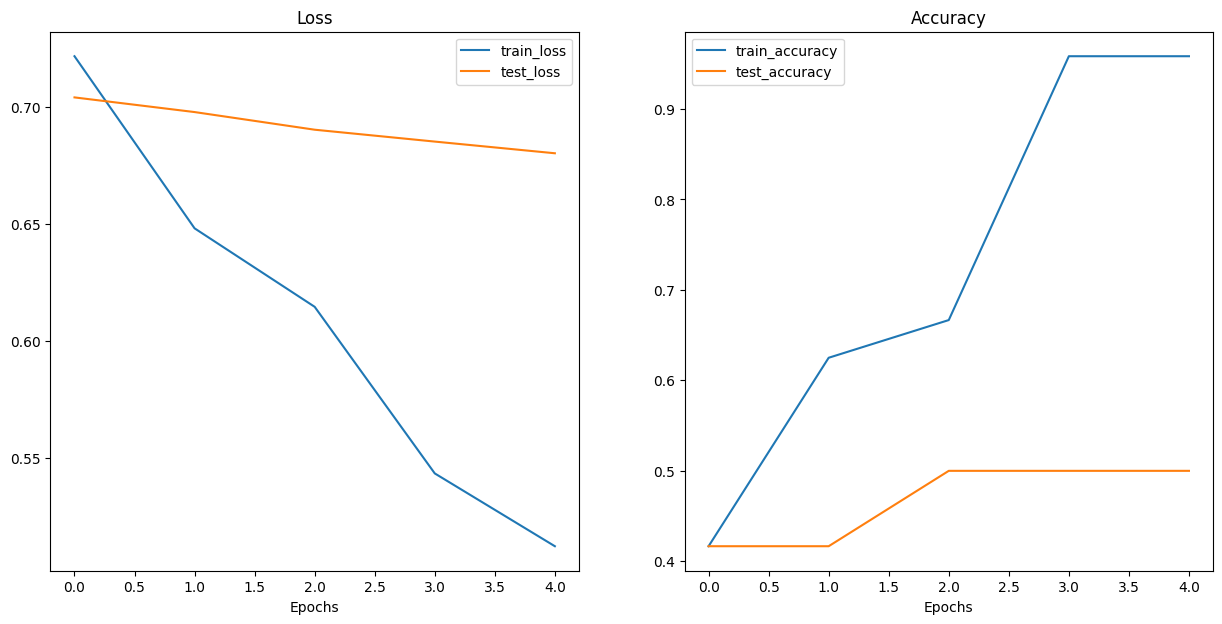

In [36]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_results)

## Use The Model

In [37]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [38]:
import requests

# Setup custom image path
test_image_path = data_path / "Arabic_Book"

# Download the image if it doesn't already exist
if not test_image_path.is_file():
    with open(test_image_path, "wb") as f:
        request = requests.get("https://www.neelwafurat.com/images/lb/hc/idautosub/10/10267.jpg")
        print(f"Downloading {test_image_path}...")
        f.write(request.content)
else:
    print(f"{test_image_path} already exists, skipping download.")

ArabicVsEnglish/Arabic_Book already exists, skipping download.


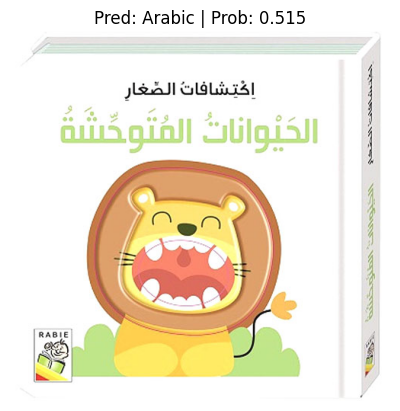

In [39]:
pred_and_plot_image(model=model,
                        image_path=test_image_path,
                        class_names=class_names,
                        image_size=(224, 224))

## Conclusion

- The model is not doing great, but it's an inital model :) and it was fun ;)
